## Importing all the required Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## data=yf.download(['NVDA','RDFN','VNET','CRWV','GRAB','AMZN','AVGO','INTC'],start='2002-01-01')

In [ ]:
data=yf.download(['NVDA','AAPL'],period='5y')
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Price            Close                    High                     Low  \
Ticker            AAPL        NVDA        AAPL        NVDA        AAPL   
Date                                                                     
2020-05-22   77.495773    8.993116   77.578398    9.059622   76.635490   
2020-05-26   76.970856    8.685746   78.795910    9.148044   76.914959   
2020-05-27   77.306213    8.493956   77.452025    8.601060   76.086269   
2020-05-28   77.340248    8.455847   78.601508    8.728342   76.703544   
2020-05-29   77.264915    8.842919   78.044999    8.842919   76.907680   
...                ...         ...         ...         ...         ...   
2025-05-15  211.449997  134.830002  212.960007  136.300003  209.539993   
2025-05-16  211.259995  135.399994  212.570007  136.350006  209.770004   
2025-05-19  208.779999  135.570007  209.479996  135.869995  204.259995   
2025-05-20  206.860001  134.380005  208.470001  134.580002  205.029999   
2025-05-21  202.089996  131.800003  207.039993  137.399994  200.710007   

Price                         Open                 Volume              
Ticker            NVDA        AAPL        NVDA       AAPL        NVDA  
Date                                                                   
2020-05-22    8.681266   76.737553    8.792854   81803200  1038764000  
2020-05-26    8.640164   78.616080    9.123135  125522000   770780000  
2020-05-27    7.967395   76.827477    8.593339  112945200  1175892000  
2020-05-28    8.348491   76.980580    8.381370  133560800   734896000  
2020-05-29    8.453853   77.583268    8.523098  153532400   745256000  
...                ...         ...         ...        ...         ...  
2025-05-15  132.660004  210.949997  134.289993   45029500   226632600  
2025-05-16  133.460007  212.360001  136.220001   54737900   226542500  
2025-05-19  132.389999  207.910004  132.389999   46140500   193154600  
2025-05-20  132.619995  207.669998  134.289993   42496600   161514200  
2025-05-21  130.589996  205.169998  133.059998   59134800   269728700  

[1256 rows x 10 columns]

In [ ]:
close=data['Close']
len(close)

1256

In [ ]:
## Pandas Backtesting

0:00:00.426579


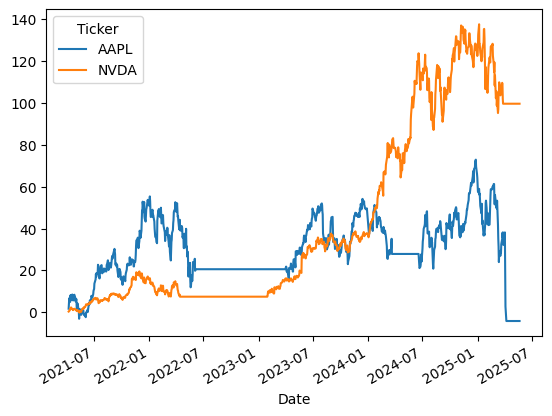

In [ ]:
def backtest(X,a,b):
    ma1=np.mean(X.iloc[-a-1:-1])
    ma2=np.mean(X.iloc[-b-1:-1])
    if ma1>ma2:
        return X.iloc[-1]-X.iloc[-2]
    elif ma2>ma1:
        ##short trade but we only want to go long thats why multiplied with 0
        return (X.iloc[-2]-X.iloc[-1])*0
    else:
        return 0


# here we use our backtest function to check crossover and Calculate PnL for ouw trade, we first take 1st 220 datapoints, then shift by one take from 2to221 data
# and we do it till wwe reach the end.
start=datetime.datetime.now()
returns=close.rolling(220).apply(lambda x:backtest(x,60,200))
print(datetime.datetime.now()-start);
returns.cumsum().plot();


## Looping Backtest

0:00:00.201966


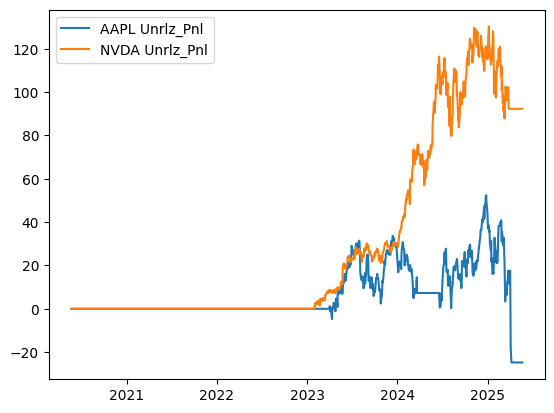

In [ ]:
start=datetime.datetime.now()
for stock in close.columns:
    ma_long=close[stock].rolling(200).mean()
    ma_short=close[stock].rolling(60).mean()
    pnl=[]
    urnlz_pnl=[]
    index=[]
    unrlz_idx=[]
    inpos=0
    entry=None
    price=close[stock]
    comms=0.005

    for i in range(len(price)):
        unrlz=(price.iloc[i]-price.iloc[i-1])*inpos
        urnlz_pnl.append(unrlz)
        unrlz_idx.append(price.index[i])

        if (ma_short.iloc[i]-ma_long.iloc[i])>0 and (ma_short.iloc[i-1]-ma_long.iloc[i-1])<0:
            entry=price.iloc[i]
            inpos=1

##writing only long only startegy , you can copy paste above if code under the following elif cose to make it long short.

        elif (ma_short.iloc[i]-ma_long.iloc[i])<0 and (ma_short.iloc[i-1]-ma_long.iloc[i-1])>0:
            if entry:
                PnL=(price.iloc[i]-entry)
                pnl.append(PnL)
                inpos=0
                index.append(price.index[i])

    #plt.plot(index,np.cumsum(pnl),label=f'{stock} Pnl')
    plt.plot(unrlz_idx,np.cumsum(urnlz_pnl),label=f'{stock} Unrlz_Pnl')
    plt.legend()

print(datetime.datetime.now()-start)

## vectorized backtest

0:00:00.045629


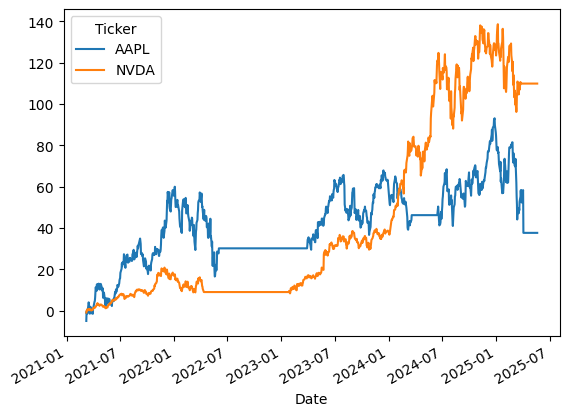

In [ ]:
start=datetime.datetime.now()
side=((np.sign((close.rolling(60).mean()-close.rolling(200).mean()))+1)/2)

(close.diff()*side.shift(-1)).cumsum().plot()
print(datetime.datetime.now()-start)

## we can see the time of backtest reduced significantly when we used vectorized backtesting, now we proceed to paramter sweep

In [ ]:
def backtest(x,a,b):
    side=((np.sign((x.rolling(a).mean()-x.rolling(b).mean()))+1)/2)
    return x.pct_change()*side.shift(-1)



def sweep(x):
    metric={}
    for a in range(2,100,2):
        for b in range (2,100,2):
            if a!=b:
                rets=backtest(x,a,b).mean(axis=1)         #Taking average returns of all the stocks
                sharpe=(np.mean(rets)/np.std(rets))*np.sqrt(252)
                metric[(a,b)]=sharpe
    return metric

sharpes=sweep(close)

/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


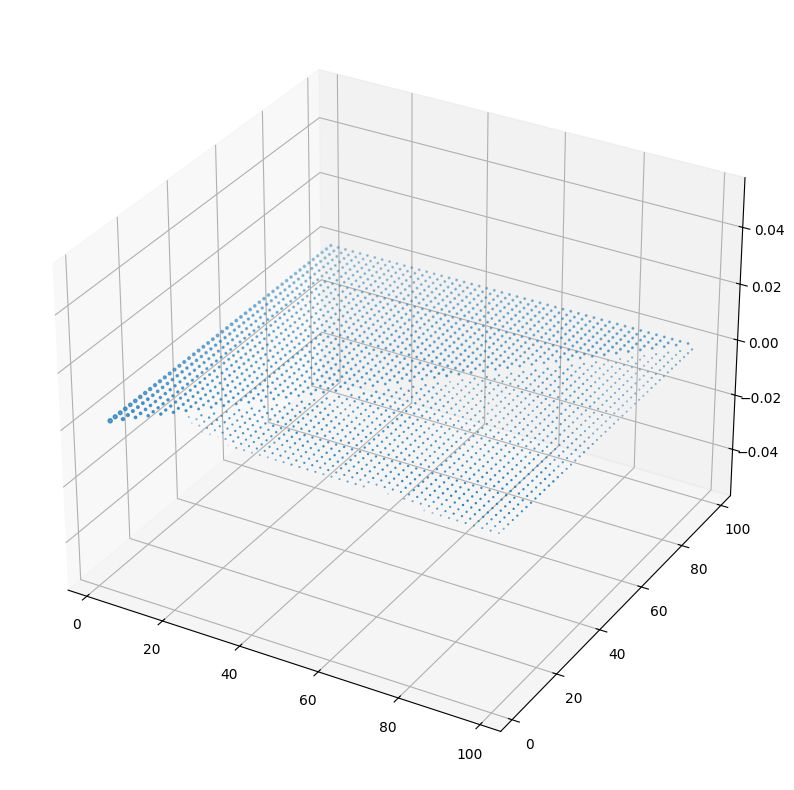

In [ ]:
X= [k[0] for k in list(sharpes.keys())]
Y=[k[1] for k in list(sharpes.keys())]
Z=list(sharpes.values())

fig=plt.figure(figsize=[15,10])
ax=fig.add_subplot(projection='3d')

plt.scatter(X,Y,Z)

## Contour Plot

In [ ]:
from scipy.interpolate import griddata

In [ ]:
XX,YY=np.meshgrid(np.arange(2,100,0.1),np.arange(2,100,0.1))
ZZ=griddata(np.array([X,Y]).T,Z,np.array([XX,YY]).T)

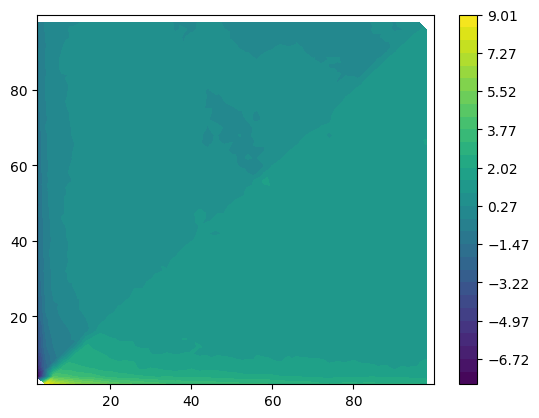

In [ ]:
fig=plt.figure()
ax=fig.add_subplot()
level=np.linspace(np.nanmin(Z),np.nanmax(Z),30)

surf=ax.contourf(XX,YY,ZZ,level)
plt.colorbar(surf)

## In sample and out of sample testing

In [ ]:
S=1000
metric1=sweep(close.iloc[:S])
metric2=sweep(close.iloc[S:])

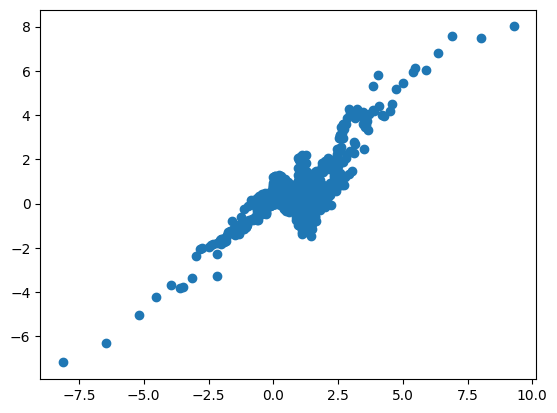

In [ ]:
plt.plot(list(metric1.values()),list(metric2.values()),'o')

[ 0.63453666 -0.18408655]


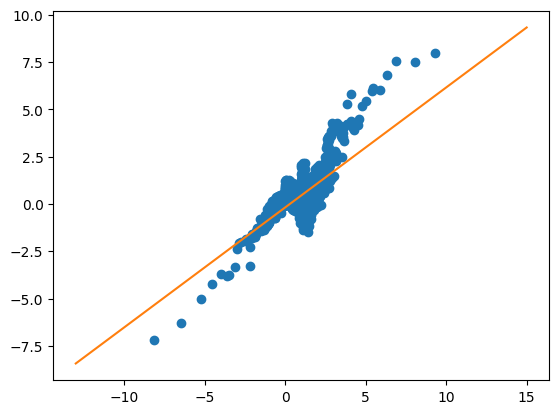

In [ ]:
plt.plot(list(metric1.values()),list(metric2.values()),'o')
m=np.polyfit(list(metric1.values()),list(metric2.values()),1)

xx=np.linspace(-13,15,200)
yy=np.polyval(m,xx)
plt.plot(xx,yy)
print(m)

## Assesing best parameter

In [ ]:
np.argsort(list(metric1.values()))
list(metric1.keys())[0]

(2, 4)

<Axes: xlabel='Date'>

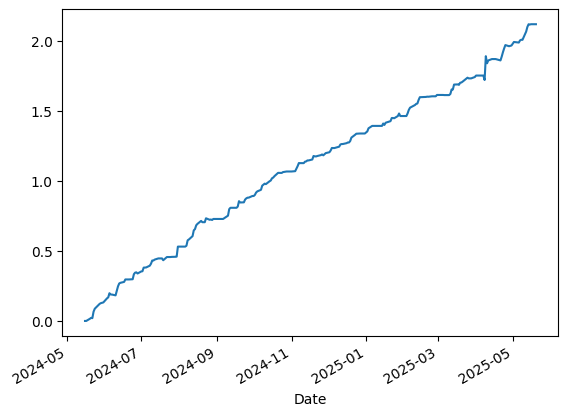

In [ ]:
rets=backtest(close.iloc[S:],2,4)
rets.mean(axis=1).cumsum().plot()

In [ ]:
day=np.sum(np.abs(np.sign(rets)),axis=0)
day

,0
Ticker,
AAPL,151.0
NVDA,136.0


In [ ]:
no_of_trade=np.abs(np.sign(rets)).diff().abs().sum(axis=0)/2

trade_time_per_trade=day/no_of_trade
trade_time_per_trade

,0
Ticker,
AAPL,5.118644
NVDA,4.317460


In [ ]:
return_per_trade=rets.sum()/no_of_trade
return_per_trade

,0
Ticker,
AAPL,0.046316
NVDA,0.091393


## Basic Portfolio Optimisation

<Axes: xlabel='Date'>

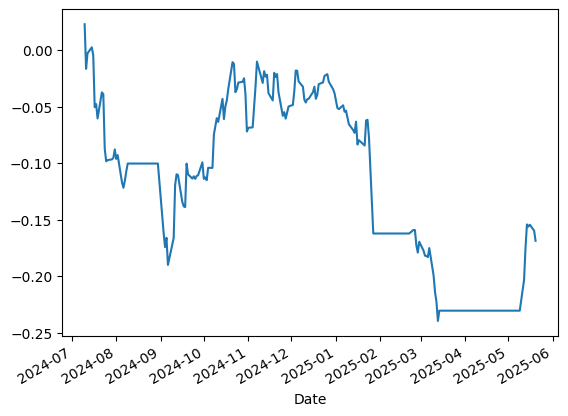

In [ ]:
rets=backtest(close.iloc[S:],20,40)
rets.mean(axis=1).cumsum().plot()

In [ ]:
rets.mean(axis=1).mean()/rets.mean(axis=1).std()*16    # sharpe ratio of portfolio traded with equal weight, multiplied by 16 which is SQRT(256) to annualize

np.float64(-0.9161971094054278)

In [ ]:
def cal_mean_var(rets,wgts):
    r=rets.apply(lambda x:np.average(x,weights=wgts),axis=1)
    return np.mean(r)*256,np.std(r)*np.sqrt(256)   # returning mean and std dev

def get_rnd_wgts(n,m):    # m is no.of stocks, n is no. of rows or weights we want
    wgts=np.random.rand(n,m)   # will create random number for each stock(total m), N no.of times.
    norm_w=wgts.T/np.sum(wgts,axis=1) #when I say axis=1, it add all weights of each stock in column, so add every column in a single row
    return norm_w.T

In [ ]:
start=datetime.datetime.now()
wgts=get_rnd_wgts(30000,2)
means=[]
vars=[]
for i,wgt in enumerate(wgts):
    mn,var=cal_mean_var(rets,wgt)
    means.append(mn)
    vars.append(var)
print(datetime.datetime.now()-start)

0:05:16.202344


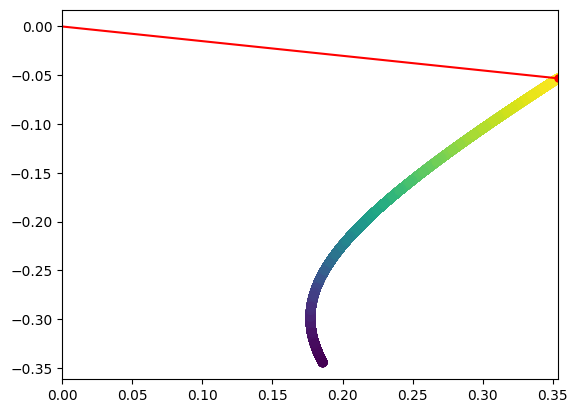

In [ ]:
plt.scatter(vars,means,c=np.divide(means,vars))  #c= something i wrote, it says color according to value you get after dividing mean and var or std, the higher it is the brighter the color
plt.xlim([0,np.max(vars)])  # we plotted vars on x axxis thats why var
# find mean and var where sharpe is high
idx=np.argmax(np.divide(means,vars))
mn,var=cal_mean_var(rets,wgts[idx])
plt.plot(var,mn,'ro',ms=5)
plt.plot([0,var],[0,mn],'r-')  # to account for interest rate add it in 0 of [0,mn], makke sure if mn is daily, then reduce interest rate of risk free rate to daily as well

<Axes: xlabel='Date'>

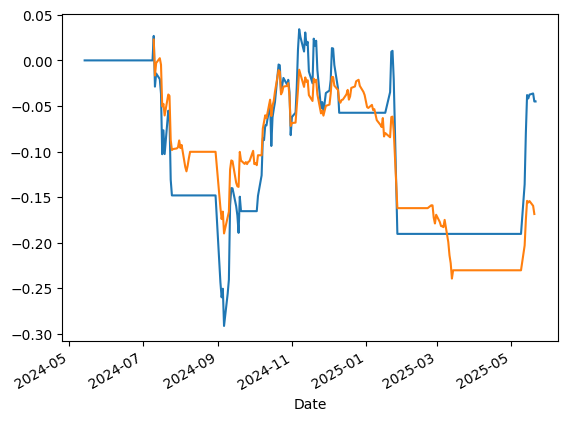

In [ ]:
(rets*wgts[idx]).sum(axis=1).cumsum().plot()
rets.mean(axis=1).cumsum().plot()

In [ ]:
rets=backtest(close,20,40)

<Axes: xlabel='Date'>

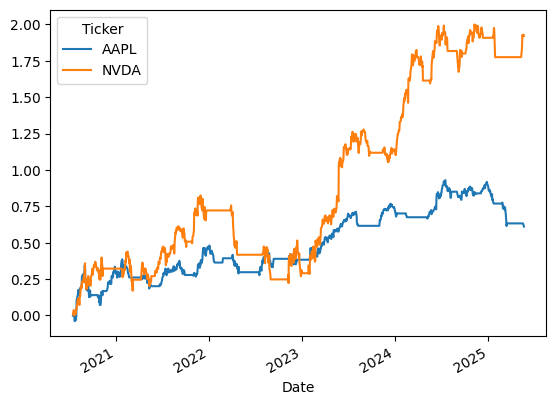

In [ ]:
rets.cumsum().plot()

In [ ]:
rets2=rets.mean(axis=1)

In [ ]:
sortino=np.mean(rets2)/np.std(rets2[rets2<=0])*16
sortino

np.float64(1.4460791089569471)

In [ ]:
Sharpe=np.mean(rets2)/np.std(rets2)*16
Sharpe

np.float64(1.026819186348043)

In [ ]:
CAGR=(1+rets2).prod()**(1/(len(rets2)/252))-1

In [ ]:
beta=close.pct_change().corrwith(rets2)
beta.mean()

np.float64(0.63801742966221)

## Monte Carlo Simulation/Analysis

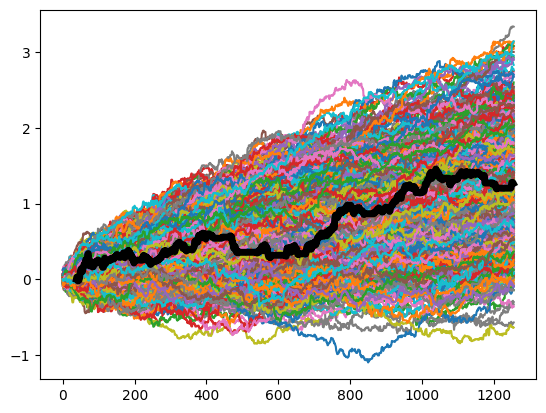

In [ ]:
final=[]
for i in range(1500):
    k=np.random.choice(rets2.fillna(0),len(rets))
    plt.plot(np.cumsum(k))
    final.append(np.sum(k))
plt.plot(np.cumsum(rets2).values,linewidth=5,color='k')     # we took .values because otherwise we will get dates on x axis

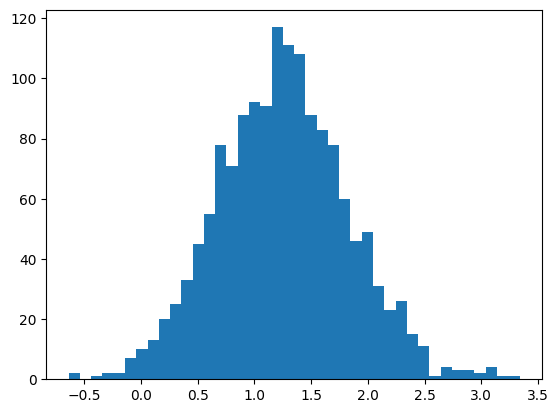

In [ ]:
plt.hist(final,40);   #to get rid of number we added ; at last, 20 is no.of bins

In [ ]:
np.mean(final),np.median(final)

(np.float64(1.2564202560917246), np.float64(1.2481263296653609))

### |Assessing the strategy by trimming tails

In [ ]:
rets=backtest(close,20,40)
rets2=rets.mean(axis=1).fillna(0)

sorted=np.argsort(rets2).values

too_bad=rets2    #when we do this it sets pointer in too_bad, which point to address of element of rets_2
#Both of them will be same in order to avoid this we do copy

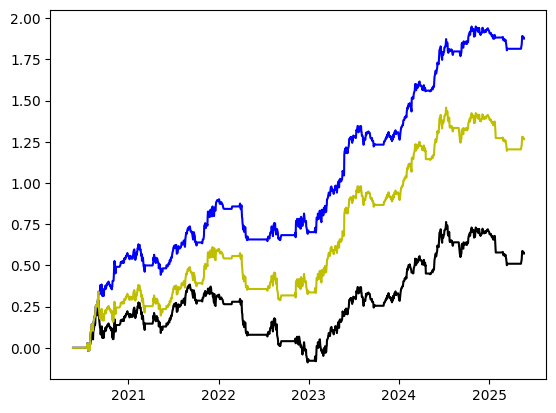

In [ ]:
from copy import copy

too_bad_2=copy(rets2)
too_good=copy(rets2)

too_bad.iloc[sorted[-10:]]=0
too_good.iloc[sorted[:10]]=0

plt.plot(np.cumsum(rets2),'k')
plt.plot(np.cumsum(too_good),'b')
plt.plot(np.cumsum(too_bad_2),'y')